<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [113]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [114]:
# Cargar datos
path = 'reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [115]:
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d]+", " ", texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())

###  `[10 pts]` Punto 2: Método del codo para determinar $K$

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



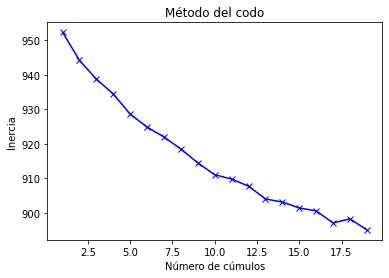

In [116]:
ks = []
k_inertias = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)
    
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-');

###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [117]:
k = 4
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

KMeans(n_clusters=4)

###  `[15 pts]` Punto 4: Interpretación de los clusters

In [118]:
data['cluster'] = model.labels_
data

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry,0
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games,0
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games,2
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games,1
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games,1
...,...,...,...,...,...,...,...,...,...
995,es_0427672,product_es_0899883,reviewer_es_0474735,2,En la foto parece que la cadena sea más gruesa...,Cadena muy fina,es,jewelry,2
996,es_0059540,product_es_0702564,reviewer_es_0754753,3,"Bien por su precio, la cadena demasiado fina.",E,es,jewelry,1
997,es_0303349,product_es_0678671,reviewer_es_0172313,5,Muy bien!! Ahora tengo organizados los pendien...,Bonito,es,jewelry,1
998,es_0659961,product_es_0294943,reviewer_es_0554554,4,"Las tapas para los joystics no están nada mal,...",No está mal pero sólo he probado las fundas.,es,video_games,2


In [119]:
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:,::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MAS REPRESENTATIVOS")
    for ind in order_centroids[3][:20]:
        print(terms[ind], end =" ")
    print()
    print()
    
    print(f"DOCUMENTOS MÁS REPRESENTATIVOS")
    for vecino in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]].review_body.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print("*********************************")
    print()

Cluster # 0
Tiene 142 registros (14.20% de los datos)

TÉRMINOS MAS REPRESENTATIVOS
me ha no el que lo llegado le la para mi he gustado es de juego un producto pero se 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** El producto en buen estado. Perfecto.

 *** Todo en perfecto estado

 *** Perfecto y en tiempo


*********************************

Cluster # 1
Tiene 292 registros (29.20% de los datos)

TÉRMINOS MAS REPRESENTATIVOS
me ha no el que lo llegado le la para mi he gustado es de juego un producto pero se 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** Son muy bonitos pero tal vez un poco más grande de lo que me esperaba. El cierre es de calidad.

 *** Es un colgante muy bonito, pero es muy muy pequeño, demasiado . El plazo de entrega ha sido muy rápido.

 *** Son unos pendientes muy bonitos y elegantes. El tamaño es el de una moneda de dos euros, quizás un poco mas pequeños. Son de plata con brillantes (circonita o algo así) en la parte delantera y con la parte de atrás abierta. Incluyen dos tipos d

###  `[BONUS: 3 pts]` Visualización usando PCA

In [120]:
terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:,::-1]

In [121]:
for ind in order_centroids[3][:20]:
    print(terms[ind], end =" ")

me ha no el que lo llegado le la para mi he gustado es de juego un producto pero se 

In [122]:
clusters = {0:'Accesorio Juegos', 1:'Juegos', 2: 'Consola', 3:'Joyas'}
data['nombres_clusters'] = data['cluster'].apply(lambda val: clusters[val])

In [123]:
data.loc[:, ['review_body', 'cluster', 'nombres_clusters']].sample(5)

,review_body,cluster,nombres_clusters
375,Llegó bien y es un juegazo,1,Juegos
385,Muy buen producto.Excelente relación calidad p...,1,Juegos
707,"El Juego es muy interesante y a buen precio, p...",2,Consola
123,Muy satisfechos con la compra. Los pendientes ...,1,Juegos
827,"La cadena es preciosa, las fotos no le hacen j...",3,Joyas


In [124]:
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
print(result.shape)
result.columns = ['X', 'Y']
result['cluster'] = data.nombres_clusters.values
result['texto'] = data.review_body.apply(lambda val: val[:140])

colorsIndx = {'Accesorio Juegos': 'blue',
              'Juegos': 'yellow',
              'Consola': 'green',
              'Joyas': 'red'
             } 

result['colores'] = result['cluster'].map(colorsIndx)

result.head()

(1000, 2)


,X,Y,cluster,texto,colores
0,0.357926,0.056089,Accesorio Juegos,"Buen. Buena calidad, y buena presentación.",blue
1,0.005329,0.075915,Accesorio Juegos,"Un producto a perfecto, para salir de casa con...",blue
2,-0.033927,0.056926,Consola,No funciona con Nintendo Switch. No hay forma ...,green
3,0.024973,0.049080,Juegos,"Recomendado, los utilizo para pc y no me dan n...",yellow
4,0.171374,-0.042864,Juegos,El cable funciona bien podria ser un poco mas ...,yellow


In [125]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Comparación

### `[BONUS 15 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [126]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]
nuevo_trans = tfidf_vect.transform(test)
[clusters[i] for i in model.predict(nuevo_trans)]

['Joyas', 'Accesorio Juegos']

In [139]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
X_train = tfidf_vect.fit_transform(train.review_body.values)
y_train = train.product_category.values
X_test = tfidf_vect.transform(test.review_body.values)
y_test = test.product_category.values

from sklearn.svm import LinearSVC
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

nuevos_trans = tfidf_vect.transform(test)
svm.predict(nuevos_trans)

array(['video_games', 'video_games', 'video_games', 'video_games',
       'video_games', 'video_games', 'video_games', 'video_games',
       'video_games', 'video_games'], dtype=object)

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
- ¿Alguna otra observación?

In [141]:
print(f'Probé con K 4, 5 y 9 pero no logro identificar correctamente las categorías para realizar la clasificación. Al final deje k=4 ya que con los otros dos valores me daba la impresión que quedaba más mezclado.')

Probé con K 4, 5 y 9 pero no logro identificar correctamente las categorías para realizar la clasificación. Al final deje k=4 ya que con los otros dos valores me daba la impresión que quedaba más mezclado.


In [96]:
print(f'Siento que las categorías quedan juntas en el anterior taller si se podía identificar la categorías gracias a la etiqueta.')

Siento que las categorias quedan juntas en el anterior taller si se podia identificar la categorias gracias a la etiqueta.


In [140]:
print(f'Intente comparar con la predicción del taller pasado pero el resultado es diferente, me clasifica todo en video_games.')

Intente comparar con la predicción del taller pasado pero el resultado es diferente, me clasifica todo en video_games.
